In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import models, layers
from sklearn.utils import class_weight
import seaborn as sns
import random
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.image as mpimg

In [3]:
base_dir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
normal_dir = os.path.join(base_dir, 'Normal')
tuberculosis_dir = os.path.join(base_dir, 'Tuberculosis')
img_size = (150, 150)
batch_size = 32
seed = 42
random.seed(seed)

In [4]:

print("Normal Samples:", len(os.listdir(normal_dir)))
print("Tuberculosis Samples:", len(os.listdir(tuberculosis_dir)))

Normal Samples: 3500
Tuberculosis Samples: 700


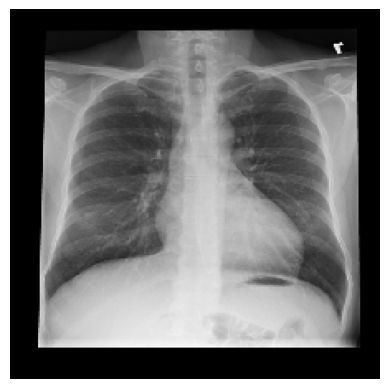

Image shape: (224, 224, 3)


In [5]:
img_path = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal/Normal-3500.png"
img = load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.axis("off")
plt.show()
img_array = img_to_array(img)
print("Image shape:", img_array.shape)

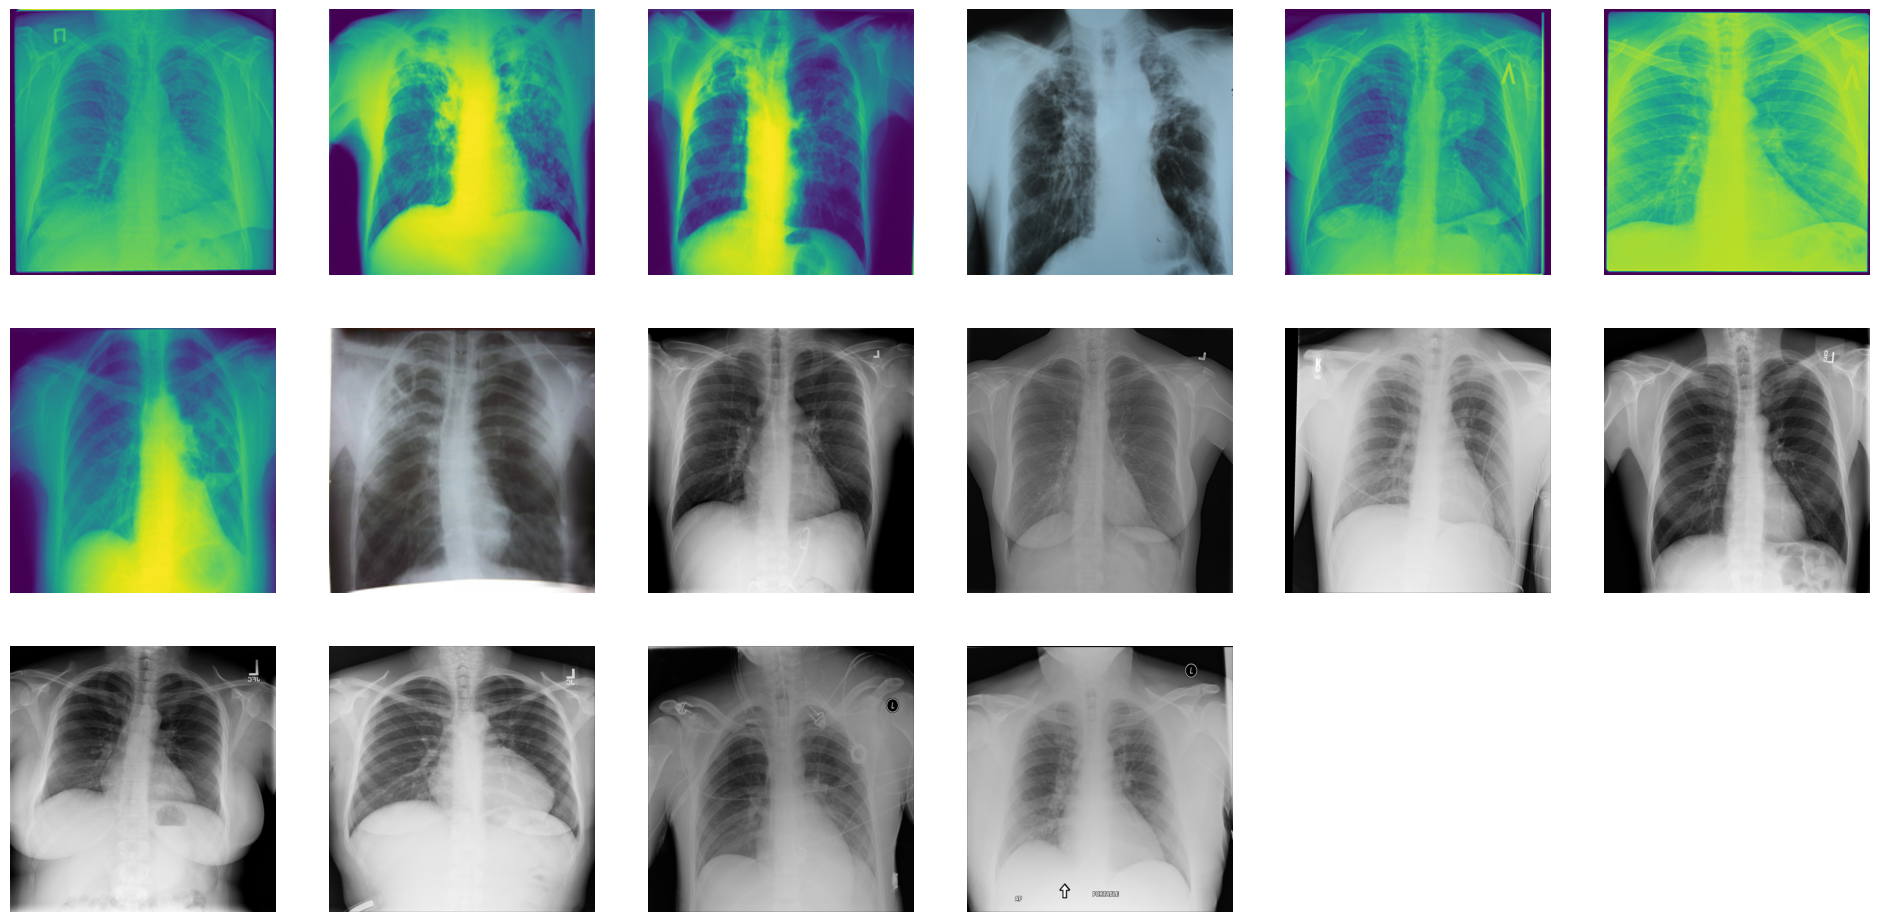

In [8]:
base_dir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'

# Define paths for Normal and Tuberculosis directories
tuberculosis_data = os.path.join(base_dir, "Tuberculosis")
normal_data = os.path.join(base_dir, "Normal")


nrows = 5
ncols = 6
pic_index = 0

# Adjusting figure size for visualization
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8  # Selecting 8 images for visualization

# Create lists of image paths for visualization
try:
    tuberculosis_img = [os.path.join(tuberculosis_data, image) for image in os.listdir(tuberculosis_data)[pic_index - 8:pic_index]]
    normal_img = [os.path.join(normal_data, image) for image in os.listdir(normal_data)[pic_index - 8:pic_index]]
    
    for i, image_path in enumerate(tuberculosis_img + normal_img):
        sp = plt.subplot(nrows, ncols, i + 1)  # Create subplot
        sp.axis('Off')  # Turn off axis for a cleaner look

        img = mpimg.imread(image_path)  # Load image
        plt.imshow(img)  # Display image

    plt.show()  # Render all images in the grid
except FileNotFoundError as e:
    print(f"Error: {e}. Please check if directories are correctly specified and exist.")

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [9]:
y_train = train_generator.classes

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: 0.6, 1: 3.0}


In [10]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745500184.160258      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weight_dict
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745500196.971720     111 service.cc:148] XLA service 0x7cc75c008b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745500196.972803     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745500197.241415     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/105 ━━━━━━━━━━━━━━━━━━━━ 15:39 9s/step - accuracy: 0.2500 - loss: 0.6251

I0000 00:00:1745500200.208146     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


105/105 ━━━━━━━━━━━━━━━━━━━━ 76s 644ms/step - accuracy: 0.7256 - loss: 0.5898 - val_accuracy: 0.8655 - val_loss: 0.4252
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 444ms/step - accuracy: 0.8685 - loss: 0.4441 - val_accuracy: 0.8714 - val_loss: 0.3852
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 435ms/step - accuracy: 0.8796 - loss: 0.4049 - val_accuracy: 0.8631 - val_loss: 0.3485
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 441ms/step - accuracy: 0.8518 - loss: 0.3812 - val_accuracy: 0.8750 - val_loss: 0.3282
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 440ms/step - accuracy: 0.8886 - loss: 0.3259 - val_accuracy: 0.8798 - val_loss: 0.3524
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 437ms/step - accuracy: 0.8840 - loss: 0.3164 - val_accuracy: 0.8655 - val_loss: 0.3512
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 436ms/step - accuracy: 0.8895 - loss: 0.3020 - val_accuracy: 0.8964 - val_loss: 0.2556
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 438ms/step - accuracy: 0.9030 - loss: 0.2740 - val

Evaluating on validation data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step
Accuracy: 0.9285714285714286

Classification Report:
               precision    recall  f1-score   support

      Normal       0.96      0.96      0.96       700
Tuberculosis       0.79      0.78      0.78       140

    accuracy                           0.93       840
   macro avg       0.87      0.87      0.87       840
weighted avg       0.93      0.93      0.93       840



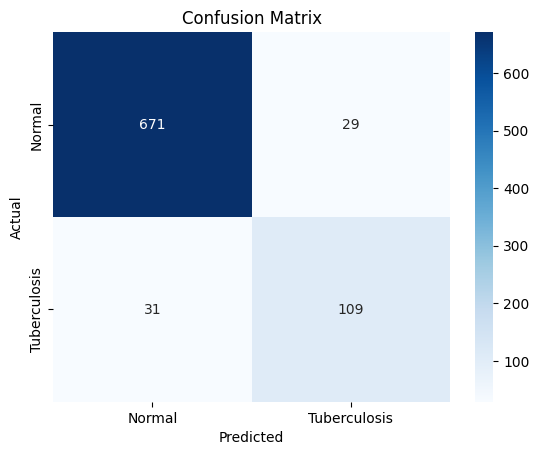

In [12]:
print("Evaluating on validation data...")
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Normal', 'Tuberculosis']))

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tuberculosis'], yticklabels=['Normal', 'Tuberculosis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

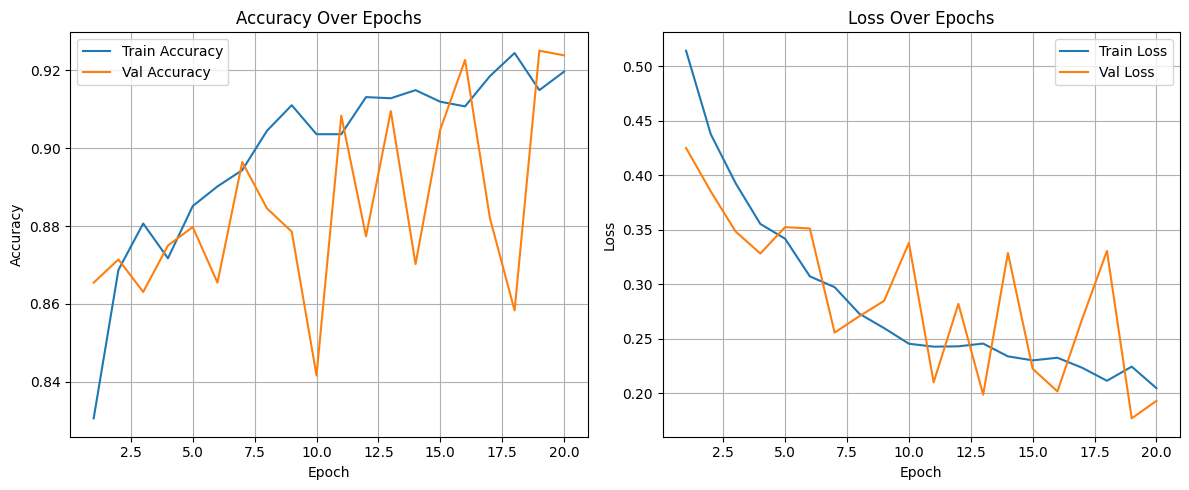

In [13]:
def plot_history(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Over Epochs")
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_history(history)  # Pass your single history object here


In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [15]:
y_train = train_generator.classes

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: 0.6, 1: 3.0}


In [16]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,634,881 (13.87 MB)

 Trainable params: 3,633,921 (13.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)
callbacks_list = [early_stop, lr_reduce]

In [18]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks_list
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 56s 451ms/step - accuracy: 0.8155 - loss: 0.6590 - val_accuracy: 0.1667 - val_loss: 1.7195 - learning_rate: 1.0000e-04
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 435ms/step - accuracy: 0.8895 - loss: 0.3976 - val_accuracy: 0.1667 - val_loss: 2.2014 - learning_rate: 1.0000e-04
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 437ms/step - accuracy: 0.9067 - loss: 0.3390 - val_accuracy: 0.5869 - val_loss: 0.9803 - learning_rate: 1.0000e-04
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 436ms/step - accuracy: 0.9176 - loss: 0.3396 - val_accuracy: 0.5643 - val_loss: 1.2103 - learning_rate: 1.0000e-04
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 439ms/step - accuracy: 0.9169 - loss: 0.3282 - val_accuracy: 0.9298 - val_loss: 0.1909 - learning_rate: 1.0000e-04
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 48s 436ms/step - accuracy: 0.9252 - loss: 0.2539 - val_accuracy: 0.8845 - val_loss: 0.3218 - learning_rate: 1.0000e-04
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 437ms/step - 

27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 353ms/step
Accuracy: 0.969047619047619

Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       700
Tuberculosis       0.95      0.86      0.90       140

    accuracy                           0.97       840
   macro avg       0.96      0.93      0.94       840
weighted avg       0.97      0.97      0.97       840



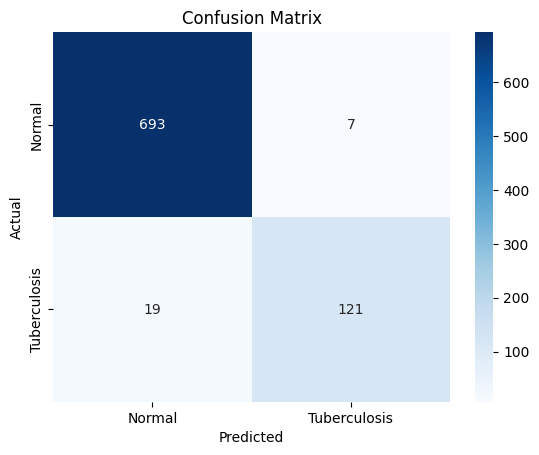

In [19]:
# print("Evaluating on validation data...")

y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

# Accuracy & Report
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Normal', 'Tuberculosis']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tuberculosis'], yticklabels=['Normal', 'Tuberculosis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


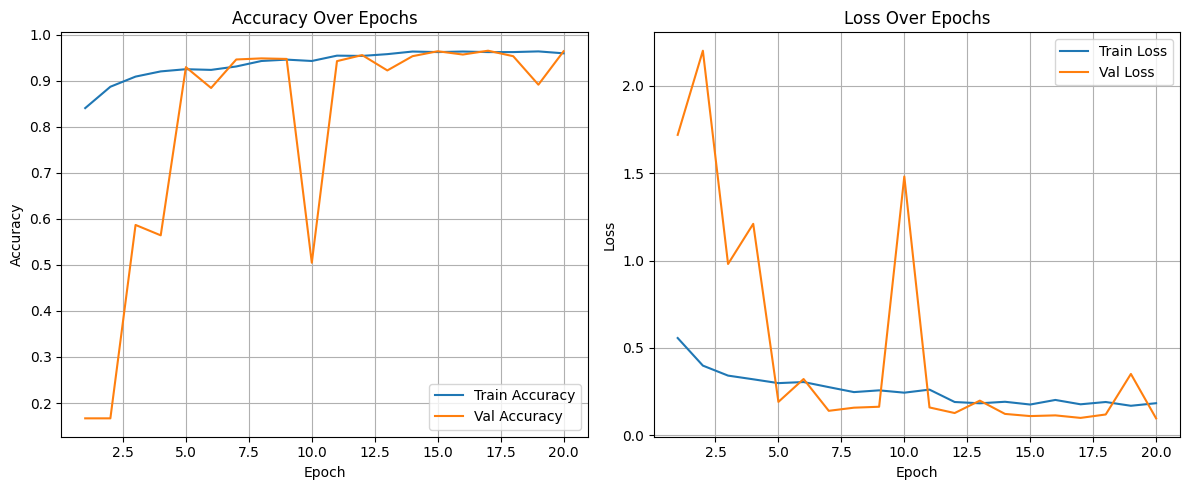

In [20]:
def plot_history(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Over Epochs")
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_history(history)  # Pass your single history object here
